# Udacity SDCND: Object Detection and Tracking
### The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles
* Estimate a bounding box for vehicles detected.

In [1]:
# Import the necessary modules
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML


import numpy as np
import pickle
import cv2
import glob
import time

#from util_tools import *

%matplotlib inline

In [2]:
cars = glob.glob("data/vehicles/**/*.png")
notcars = glob.glob("data/non-vehicles/**/*.png")
print("The number of images with car is {}\n\
The number of images without car is {}".format(len(cars), len(notcars)))

The number of images with car is 8792
The number of images without car is 8968


# Let us Visualize the data first

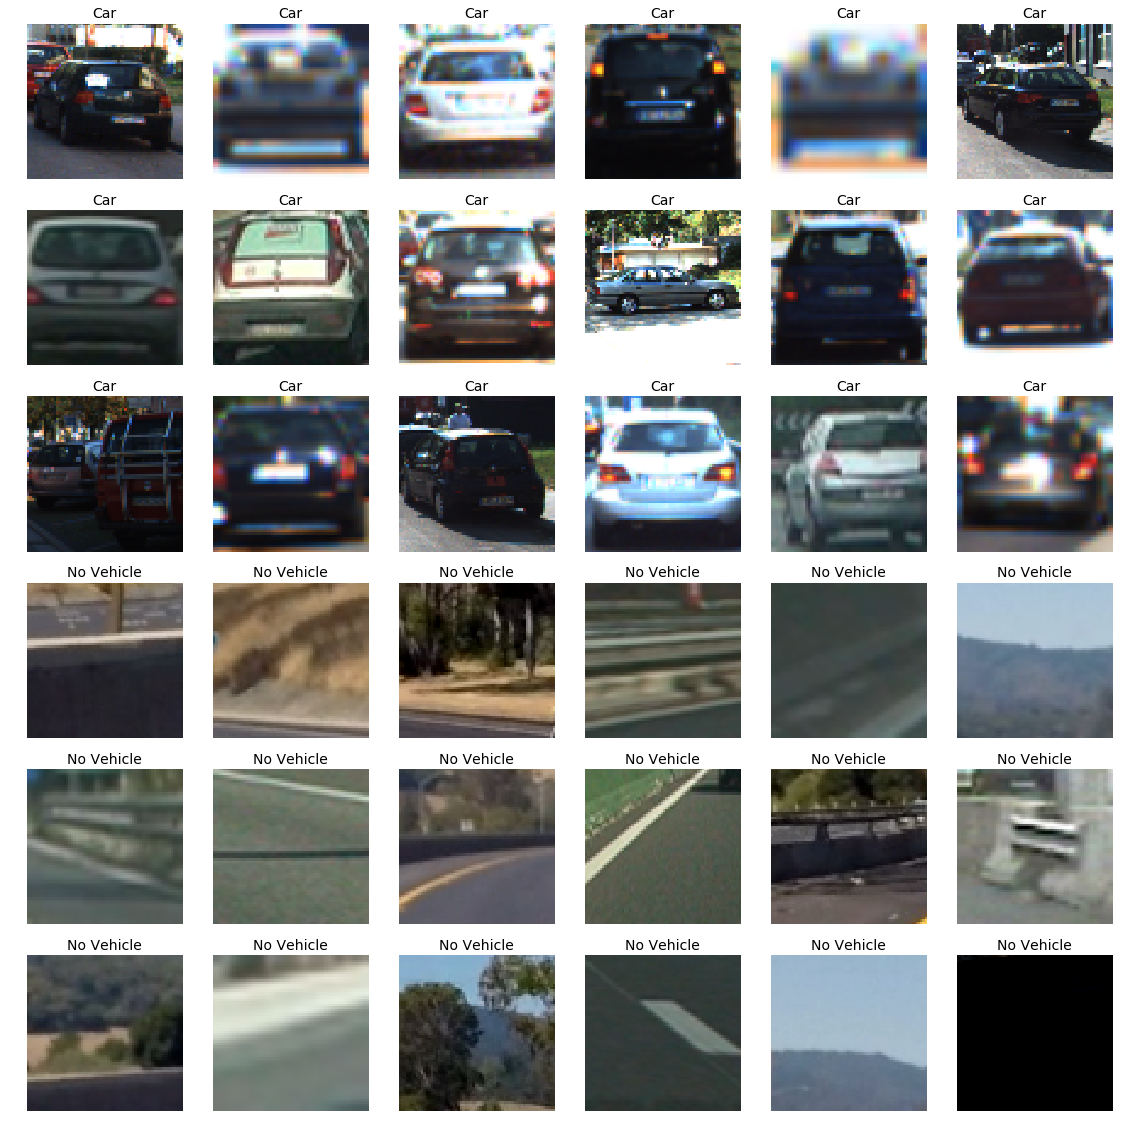

In [3]:
fig, axs = plt.subplots(6,6, figsize=(20, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(18):
    img = mpimg.imread(cars[np.random.randint(0,len(cars))])
    axs[i].axis('off')
    axs[i].set_title('Car', fontsize=14)
    axs[i].imshow(img)
for i in range(18,36,1):
    img = mpimg.imread(notcars[np.random.randint(0,len(notcars))])
    axs[i].axis('off')
    axs[i].set_title('No Vehicle', fontsize=14)
    axs[i].imshow(img)

# Useful functions used from the class material

* __get_hog_features()__: Function takes an image and uses Scikit Learn ```hog``` function to calculate Histogram of Gradient features. It can also return Hog feature vectors.
* __bin_spatial()__: The function takes a 2D image (3 channel), it resizes it to the size required and convert it to 1D feature vector containing the actual value of the three channels (clolor) of the image  using `ravel` function.
* __color_hist()__ : The function takes a 3-channel 2D image, and generates the histogram of the colour value for the three colour channels.
* __img_features()__: This function performs the process of extracting bin-spatial, color_hist and hog features of an image.
* __extract_features()__: This function performs the process of extracting bin-spatial, color_hist and hog features for a list of images, it makes use of `img_feature` function. Also it takes care of the color space we want to work in.
* __draw_boxes()__: Adds rectangle at the specified points to the given image.
* __show_image()__: Displays an image.

In [4]:
import cv2
from skimage.feature import hog
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True: # Call with two outputs if vis==True to visualize the HOG
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  block_norm= 'L2-Hys', transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      # Otherwise call with one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys', transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins)[0]
    ch2 = np.histogram(img[:,:,1], bins=nbins)[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins)[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist

# Define a function to extract features from a list of images
def img_features(feature_image, spatial_size, spatial_feat, hist_feat, hog_feat, hist_bins, 
                 orient, pix_per_cell, cell_per_block, hog_channel):
    img_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
         # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, ))
                       
        else:
            hog_features = get_hog_features(feature_image[:,:, hog_channel], orient, pix_per_cell, 
                                            cell_per_block, vis=False)
            #print ('hog', hog_features.shape)
            # Append the new feature vector to the features list
        img_features.append(hog_features)
    return img_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file_p in imgs:
        file_features = []
        image = mpimg.imread(file_p) # Read in each imageone by one
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        file_features = img_features(feature_image, spatial_size, spatial_feat, hist_feat, hog_feat, 
                                     hist_bins, orient, pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
        feature_image=cv2.flip(feature_image,1) # Augment the dataset with flipped images
        file_features = img_features(feature_image, spatial_size, spatial_feat, hist_feat, hog_feat, 
                                     hist_bins, orient, pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
    return features # Return list of feature vectors


# Define a function to draw bounding boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        #print(bbox[0], bbox[1])
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy


# A function to show an image
def show_image(img):
    if len(img.shape)==3: #Color BGR image
        plt.figure(figsize=(10,10))
        plt.imshow(img)
    else: # Grayscale image
        plt.figure(figsize=(10,10))
        plt.imshow(img, cmap='gray')

## Analyze Features

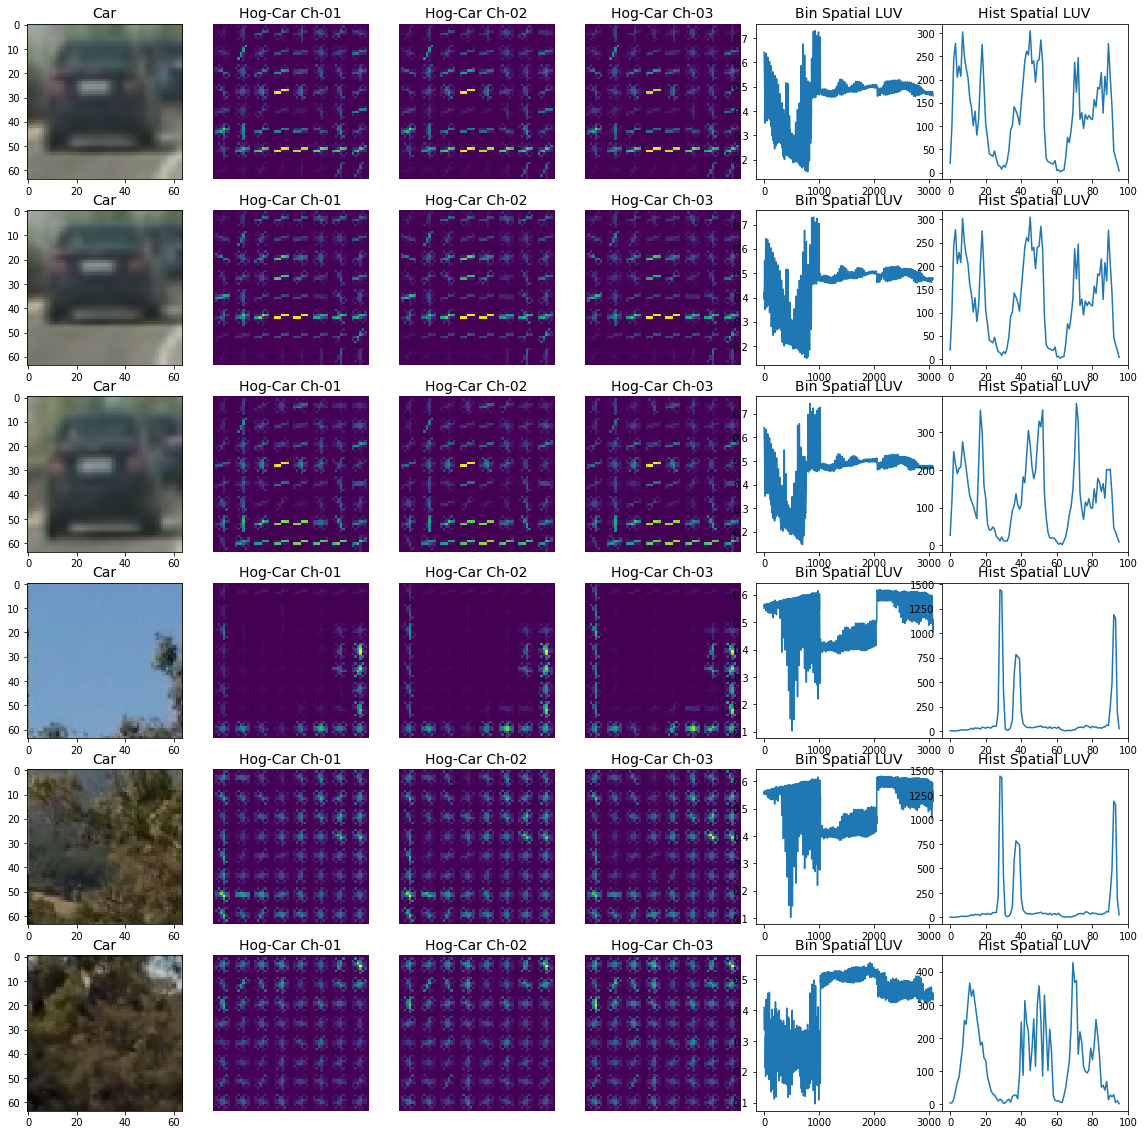

In [5]:
# Visualize HOG images for vehicles and no vehicles
fig, axs = plt.subplots(6,6, figsize=(20, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
cspace = 'YCrCb'

images = cars[0:3]
img1 = extract_features(images, color_space=cspace,
            hist_feat=False, hog_feat=False) 
img2 = extract_features(images, color_space=cspace,
            spatial_feat=False, hog_feat=False) 
ct = 0

#print(np.shape(hog1))
for i in range(0,18,6):
    img = mpimg.imread(images[ct])
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    _, hog1 = get_hog_features(img[:,:,0], orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    _, hog2 = get_hog_features(img[:,:,1], orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    _, hog3 = get_hog_features(img[:,:,2], orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    axs[i].set_title('Car', fontsize=14)
    axs[i].imshow(img)
    axs[i+1].axis('off')
    axs[i+1].set_title('Hog-Car Ch-01', fontsize=14)
    axs[i+1].imshow(hog1)
    axs[i+2].axis('off')
    axs[i+2].set_title('Hog-Car Ch-02', fontsize=14)
    axs[i+2].imshow(hog2)
    axs[i+3].axis('off')
    axs[i+3].set_title('Hog-Car Ch-03', fontsize=14)
    axs[i+3].imshow(hog3)
    axs[i+4].set_title('Bin Spatial LUV', fontsize=14)
    axs[i+4].plot(img1[ct])
    axs[i+5].set_title('Hist Spatial LUV', fontsize=14)
    axs[i+5].hist(img2[ct])
    ct += 1


images = notcars[0:3]
img1 = extract_features(images, color_space=cspace,
            hist_feat=False, hog_feat=False) 
img2 = extract_features(images, color_space=cspace,
            spatial_feat=False, hog_feat=False) 
ct = 0
for i in range(18,36,6):
    img = mpimg.imread(images[ct])
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    _, hog1 = get_hog_features(img[:,:,0], orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    _, hog2 = get_hog_features(img[:,:,1], orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    _, hog3 = get_hog_features(img[:,:,2], orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    axs[i].set_title('Car', fontsize=14)
    axs[i].imshow(img)
    axs[i+1].axis('off')
    axs[i+1].set_title('Hog-Car Ch-01', fontsize=14)
    axs[i+1].imshow(hog1)
    axs[i+2].axis('off')
    axs[i+2].set_title('Hog-Car Ch-02', fontsize=14)
    axs[i+2].imshow(hog2)
    axs[i+3].axis('off')
    axs[i+3].set_title('Hog-Car Ch-03', fontsize=14)
    axs[i+3].imshow(hog3)
    axs[i+4].set_title('Bin Spatial LUV', fontsize=14)
    axs[i+4].plot(img1[ct])
    axs[i+5].set_title('Hist Spatial LUV', fontsize=14)
    axs[i+5].hist(img2[ct])
    ct += 1

In [6]:
# Define parameters for feature extraction
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [7]:
# Extract Features for training the Classifier
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('Car samples: ', len(car_features))
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('Notcar samples: ', len(notcar_features))
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = MinMaxScaler().fit(X) # Fit a per-column scaler
scaled_X = X_scaler.transform(X) # Apply the scaler to X

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels vector

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=333)


Car samples:  17584
Notcar samples:  17936


In [8]:
# Training the Classifier
print('Using:',orient,'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC(loss='squared_hinge', random_state=333) # Use a linear SVC 
t=time.time() # Check the training time for the SVC
svc.fit(X_train, y_train) # Train the classifier
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
363.88 Seconds to train SVC...
Test Accuracy of SVC =  0.9903


In [9]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows+1):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows



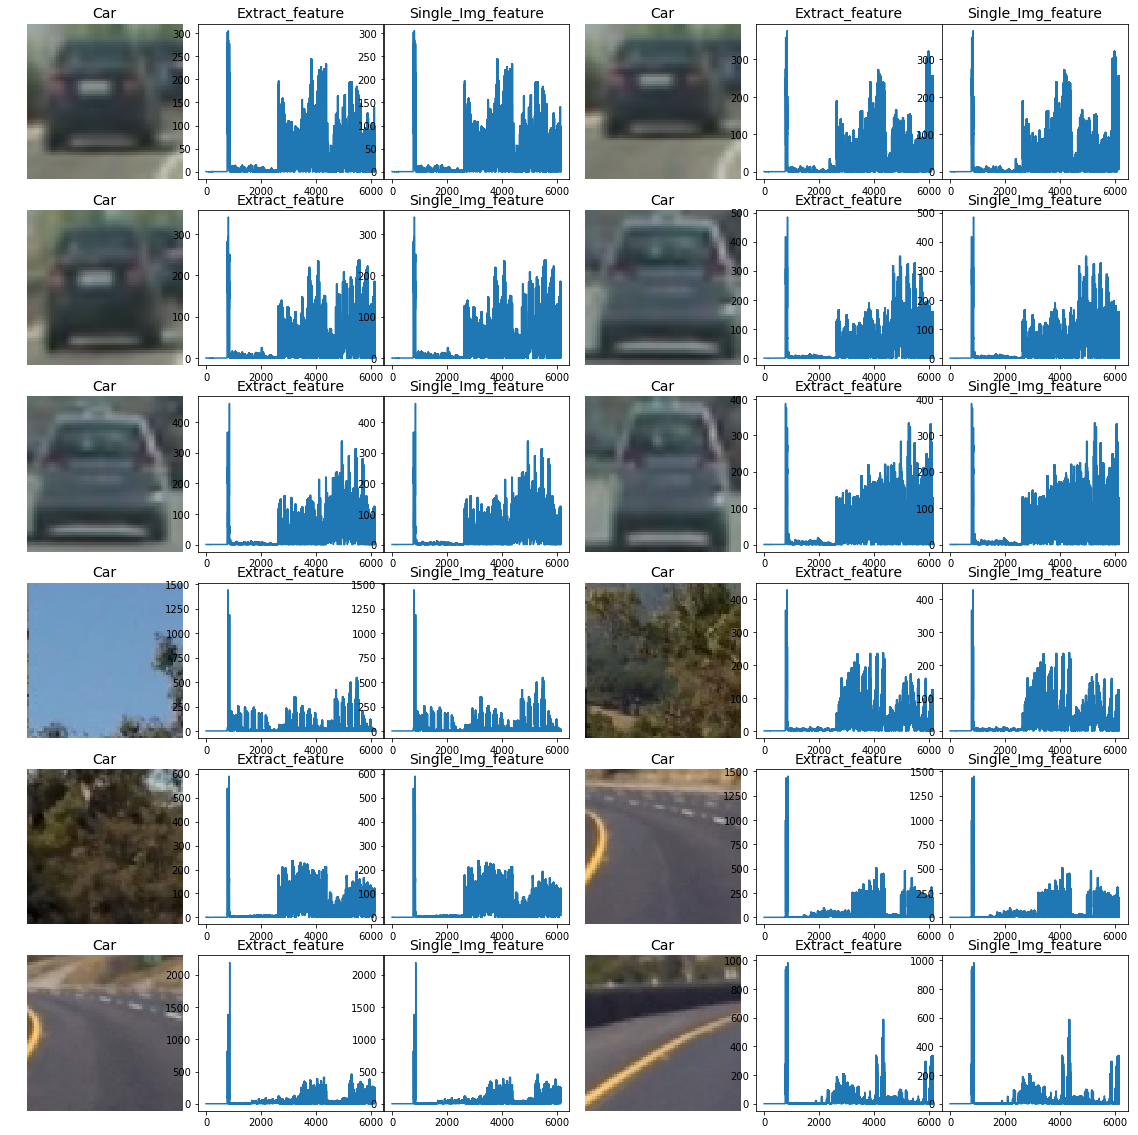

In [10]:
# Visualize result of extract_feature and single_img_feature They should be same
fig, axs = plt.subplots(6,6, figsize=(20, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
images = cars[0:6]

count = 0
count2 = 0
features1 = extract_features(images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


for i in range(0,18,3):
    image = mpimg.imread(images[count])
    features2 = single_img_features(image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    axs[i].axis('off')
    axs[i].set_title('Car', fontsize=14)
    axs[i].imshow(image)
    axs[i+1].set_title('Extract_feature', fontsize=14)
    axs[i+1].plot(features1[count2])
    axs[i+2].set_title('Single_Img_feature', fontsize=14)
    axs[i+2].plot(features2)
    count += 1
    count2 +=2
    
count = 0
count2 = 0
images = notcars[0:6]
features1 = extract_features(images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)



for i in range(18,36,3):
    image = mpimg.imread(images[count])
    features2 = single_img_features(image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    axs[i].axis('off')
    axs[i].set_title('Car', fontsize=14)
    axs[i].imshow(image)
    axs[i+1].set_title('Extract_feature', fontsize=14)
    axs[i+1].plot(features1[count2])
    axs[i+2].set_title('Single_Img_feature', fontsize=14)
    axs[i+2].plot(features2)
    count += 1
    count2 +=2
    


12.6 Seconds to process test images


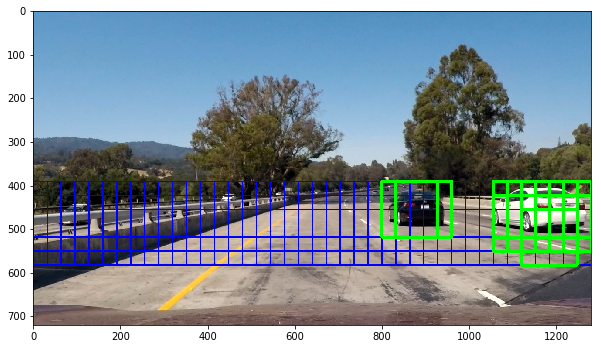

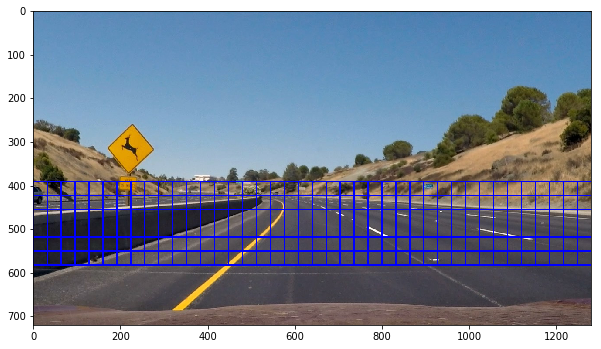

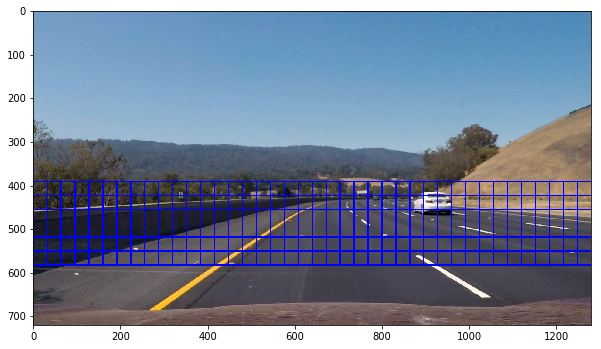

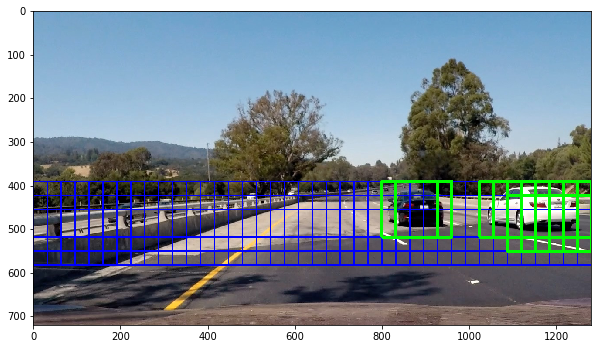

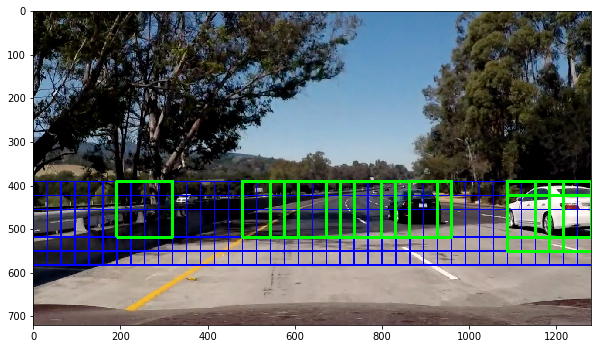

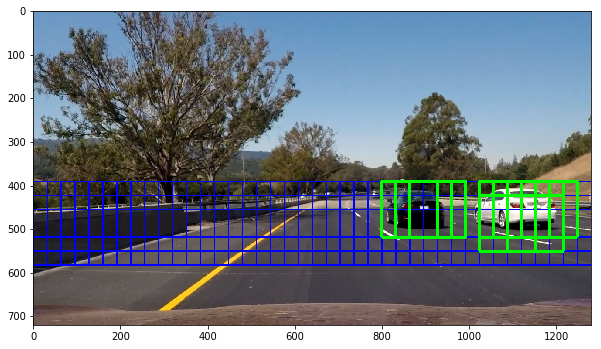

In [11]:
# Testing the classifier
t=time.time() # Start time
for image_p in glob.glob('test_images/test*.jpg'):
    image = mpimg.imread(image_p)
    draw_image = np.copy(image)
    draw_image = draw_image.astype(np.float32)/255.0 # Because we trained on png and this is jpg
    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[390, 600], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    hot_windows = []
    hot_windows += (search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))  
    
    window_img = draw_boxes(draw_image, windows, color=(0, 0, 1), thick=2)
    window_img = draw_boxes(window_img, hot_windows, color=(0, 1, 0), thick=6)                    
    show_image(window_img)
print(round(time.time()-t, 2), 'Seconds to process test images')

| S.No.  | Color Space  |  Orient |  Pix/Cell | Cell/block  |SVC Accuracy|
|---|---|---|---|---|---|
|  1 |  RGB |8   |  8 |  2 |  96.92 |
| 2  |  HSV | 8  |   8|   2| 96.62 |
|  3 |   HLS|   8|  8 |  2 | 97.62 |
|4 |YCrCb| 8|8|2| 97.62 |
|5 | LUV | 8 | 8| 2| 95.57|
|6 | YUV| 8|8|2| 97.38|

Though as per the table accuracy of RGB is highest, it was observed that on test images, RGB results in lots of False positives, while YCrCb and LUV were doing good. 

I decide to choose YCrCb channel


 Next for accuracy we divide window search area into two parts:
 * Left and right areas searching any news cars overtaking our car.
 * Front area searching cars ahead


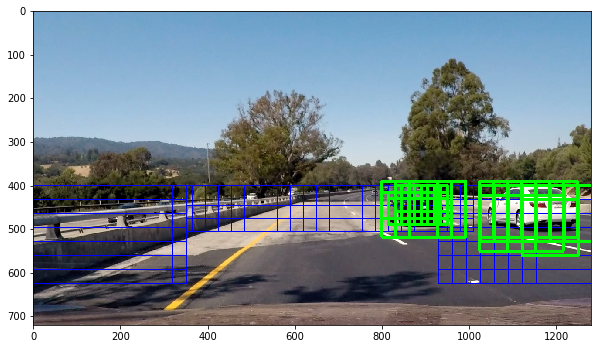

In [12]:
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)
draw_image = draw_image.astype(np.float32)/255 

windows = slide_window(draw_image, x_start_stop=[930, None], y_start_stop=[400, 650], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
windows += slide_window(draw_image, x_start_stop=[0, 350], y_start_stop=[400, 650], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
#draw = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6) 
windows += slide_window(draw_image, x_start_stop=[350, 1000], y_start_stop=[400, 510], 
                    xy_window=(60, 60), xy_overlap=(0.75, 0.75))
draw = draw_boxes(draw_image, windows, color = (0,0,1), thick=1)   

hot_windows += (search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))  

window_img = draw_boxes(draw, hot_windows, color=(0, 1, 0), thick=6)  
    
show_image(window_img)

In [13]:
def convert_color(img, conv='RGB2YcrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
    
def find_cars(img, ystart, ystop, xstart, xstop, scale, step, spatial_size=(16, 16),
                        hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Consider edge cases
    if xstart == None:
        xstart = 0
    if xstop == None:
        xstop = img.shape[1]
    if ystart == None:
        ystart = 0
    if ystop == None:
        ystop = img.shape[0]
        
    boxes = []
    windows = []
    #draw_img = np.zeros_like(img) 
    img = img.astype(np.float32)/255 
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    
    ctrans_tosearch = convert_color(img_tosearch, 'RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))       
    
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1,orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
                       
   
    count = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            #print(count)
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog1_feat = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog2_feat = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog3_feat = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog1_feat, hog2_feat, hog3_feat))
            else:
                hog_features = hog1_feat
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
            #subimg = ctrans_tosearch[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]
            windows.append(((xleft, ytop), (xleft+window, ytop+window)))
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))        
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    return boxes  #, windows, ctrans_tosearch

4 boxes found in image


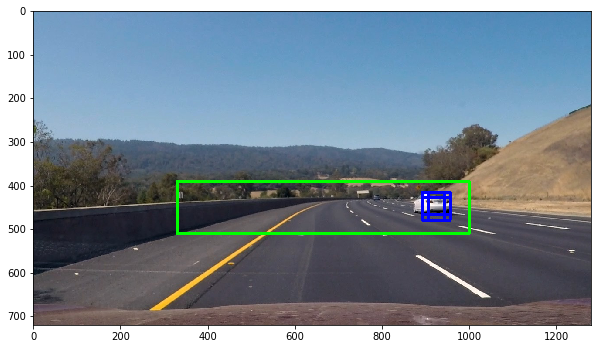

In [14]:
test_img = mpimg.imread('./test_images/test3.jpg')
#test_img = test_img.astype(np.float32)/255 

ystart, ystop, xstart, xstop, scale, step, window = 390, 510, 330, 1000, 0.8, 2, 64
bboxes = [((xstart, ystart), (xstop, ystop))]
boxes = find_cars(test_img, ystart, ystop, xstart, xstop, scale, step,  
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
result = draw_boxes(test_img, bboxes,color=(0, 255, 0), thick=6 )
#Im = draw_boxes(Im, W, color=(0, 1, 0), thick=2 )
result = draw_boxes(result, boxes, color=(0, 0, 255), thick=6)

print(len(boxes), 'boxes found in image')
show_image(result)
#show_image(Im)


43 boxes found in image


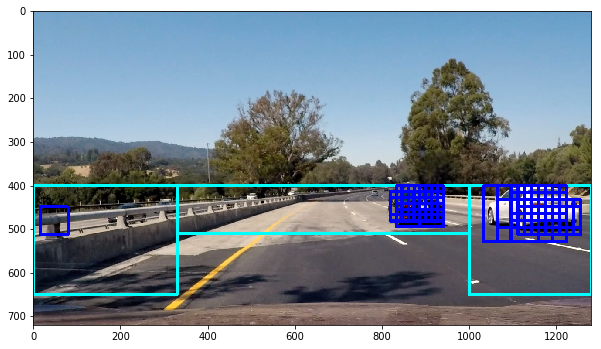

In [15]:
test_img = mpimg.imread('./test_images/test4.jpg')
#test_img = test_img.astype(np.float32)/255 




ystart, ystop, xstart, xstop, scale, step, window = 400, 650, 1000, 1280, 2.0, 2, 64
bboxes = [((xstart, ystart), (xstop, ystop))]
boxes = find_cars(test_img, ystart, ystop, xstart, xstop, scale, step,  
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

ystart, ystop, xstart, xstop, scale, step, window = 400, 650, 1000, 1280, 1.0, 2, 64
bboxes += [((xstart, ystart), (xstop, ystop))]
boxes += find_cars(test_img, ystart, ystop, xstart, xstop,scale, step,  
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


ystart, ystop, xstart, xstop, scale, step, window = 400, 650, 0, 330, 2.0, 2, 64
bboxes += [((xstart, ystart), (xstop, ystop))]
boxes += find_cars(test_img, ystart, ystop, xstart, xstop, scale, step,  
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


ystart, ystop, xstart, xstop, scale, step, window = 400, 650, 0, 330, 1.0, 2, 64
bboxes += [((xstart, ystart), (xstop, ystop))]
boxes += find_cars(test_img, ystart, ystop, xstart, xstop, scale, step,  
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


ystart, ystop, xstart, xstop, scale, step, window = 400, 510, 330, 1000, 0.85, 2, 64
bboxes += [((xstart, ystart), (xstop, ystop))]
boxes += find_cars(test_img, ystart, ystop, xstart, xstop, scale, step, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

#Im = draw_boxes(Im, W, color=(0, 255, 0), thick=2 )

result = draw_boxes(test_img, bboxes,color=(0, 255, 255), thick=6 )
result = draw_boxes(result, boxes, color=(0, 0, 255), thick=6)

print(len(boxes), 'boxes found in image')
show_image(result)


In [16]:
from scipy.ndimage.measurements import label

THRES = 3 # Minimal overlapping boxes
ALPHA = 0.75 # Filter parameter, weight of the previous measurements

image = mpimg.imread('test_images/test5.jpg')
track_list = []
THRES_LEN = 30
Y_MIN = 440

heat_p = np.zeros((720, 1280)) # Store prev heat image
boxes_p = [] # Store prev car boxes
n_count = 0 # Frame counter

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap # Return updated heatmap
    
def apply_threshold(heatmap, threshold=2): # Zero out pixels below the threshold in the heatmap
    heat_th = np.copy(heatmap)
    heat_th[heat_th < threshold] = 0 
    return heat_th 

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

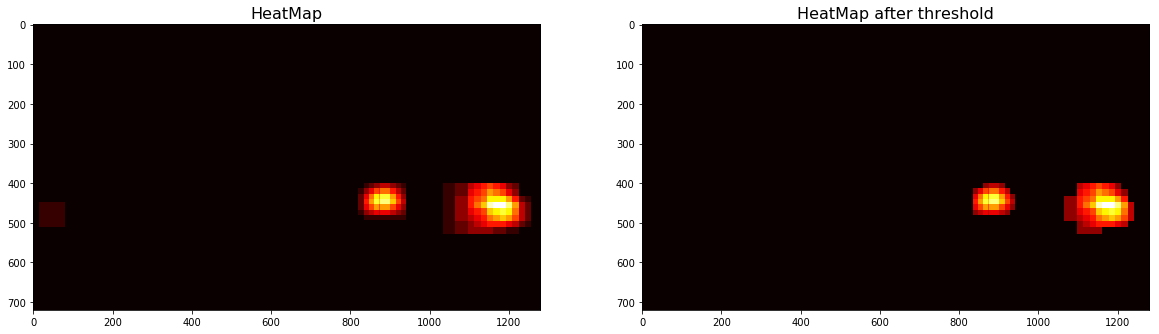

In [17]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, boxes)
heatmap_img2 = apply_threshold(heatmap_img, 3)
fig, [ax1,ax2] = plt.subplots(1,2, figsize= (20,20))
ax1.set_title("HeatMap", fontsize=16)
ax1.imshow(heatmap_img, cmap='hot')
ax2.set_title("HeatMap after threshold", fontsize=16)
ax2.imshow(heatmap_img2, cmap='hot')

10.03 Seconds to process test images


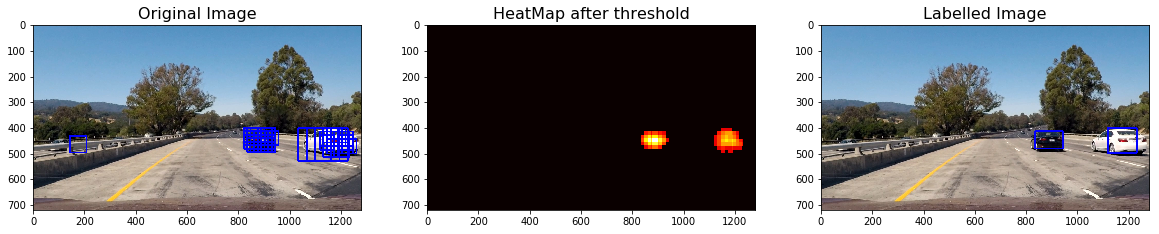

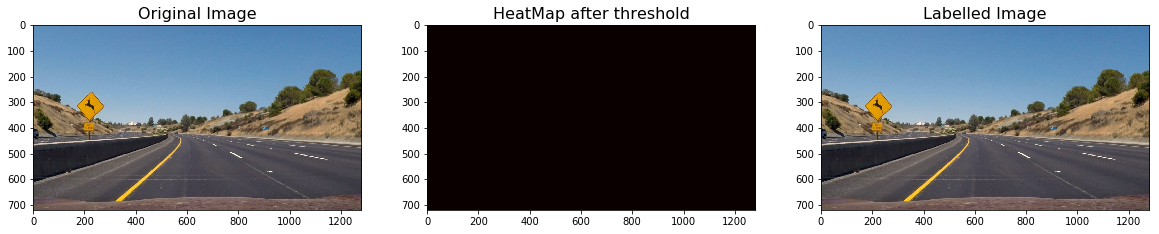

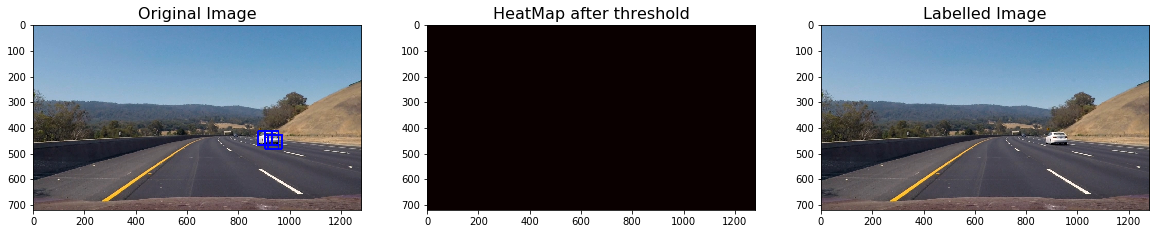

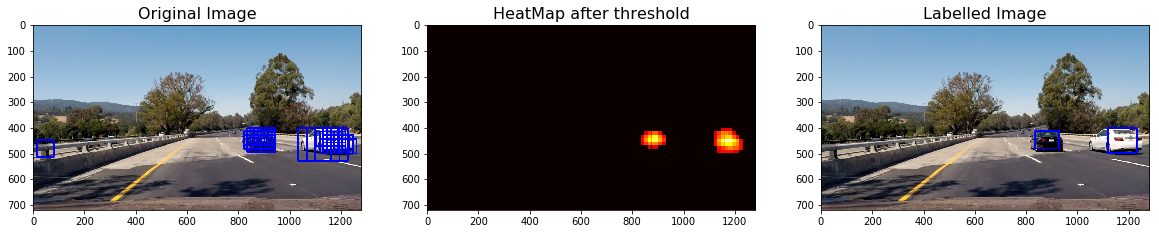

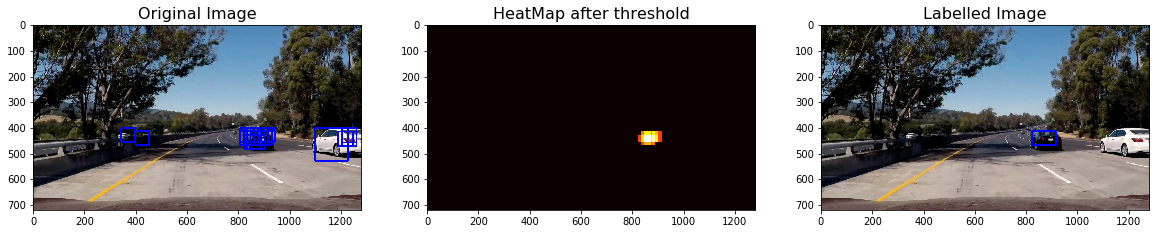

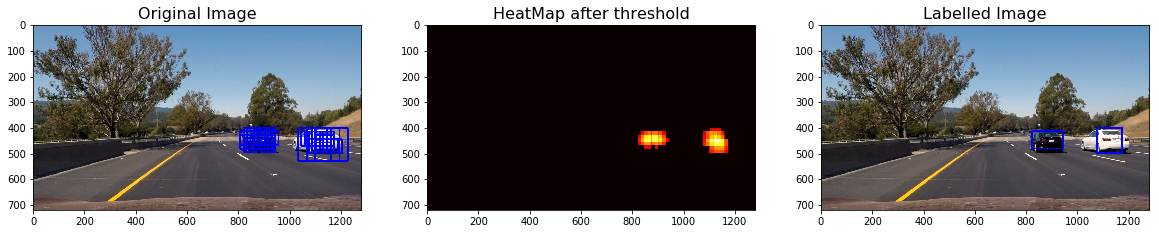

In [18]:
t=time.time() # Start time

for image_p in glob.glob('test_images/test*.jpg'):
    test_img = mpimg.imread(image_p)
    ystart, ystop, xstart, xstop, scale = 400, 650, 1000, 1280, 2.0
    boxes = find_cars(test_img, ystart, ystop, xstart, xstop, scale, 2,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    ystart, ystop, xstart, xstop, scale = 400, 650, 1000, 1280, 0.9
    boxes += find_cars(test_img, ystart, ystop, xstart, xstop, scale, 2,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    ystart, ystop, xstart, xstop, scale = 400, 650, 0, 330, 2.0
    boxes += find_cars(test_img, ystart, ystop, xstart, xstop, scale, 2,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    ystart, ystop, xstart, xstop, scale = 400, 650, 0, 330, 1.0
    boxes += find_cars(test_img, ystart, ystop, xstart, xstop, scale, 2,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    ystart, ystop, xstart, xstop, scale = 400, 510, 330, 1000, 0.85
    boxes += find_cars(test_img, ystart, ystop, xstart, xstop, scale, 2,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    
    result = draw_boxes(test_img, boxes, color=(0, 0, 255), thick=6)
    heatmap_img = np.zeros_like(test_img[:,:,0])
    heatmap_img = add_heat(heatmap_img, boxes)
    heatmap_img2 = apply_threshold(heatmap_img, 5)
    labels = label(heatmap_img2)
    draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
    fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize= (20,20))
    ax1.set_title("Original Image", fontsize=16)
    ax1.imshow(result)
    ax2.set_title("HeatMap after threshold", fontsize=16)
    ax2.imshow(heatmap_img2, cmap='hot')
    ax3.set_title("Labelled Image", fontsize=16)
    ax3.imshow(draw_img)
    
print(round(time.time()-t, 2), 'Seconds to process test images')
    
    
    

# Primitive Pipeline for Video

Here the video is processed each frame at a time without considering the information from previous frames.

In [24]:
def process_image(img):
    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    
    ystart, ystop, xstart, xstop, scale = 400, 650, 1000, 1280, 2.0
    boxes = find_cars(img, ystart, ystop, xstart, xstop, scale, 2,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    ystart, ystop, xstart, xstop, scale = 400, 650, 1000, 1280, 0.9
    boxes += find_cars(img, ystart, ystop, xstart, xstop, scale, 2,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    ystart, ystop, xstart, xstop, scale = 400, 650, 0, 330, 2.0
    boxes += find_cars(img, ystart, ystop, xstart, xstop, scale, 2,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    ystart, ystop, xstart, xstop, scale = 400, 650, 0, 330, 1.0
    boxes += find_cars(img, ystart, ystop, xstart, xstop, scale, 2,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    ystart, ystop, xstart, xstop, scale = 400, 510, 330, 1000, 0.85
    boxes += find_cars(img, ystart, ystop, xstart, xstop, scale, 2,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, boxes)
    heatmap_img2 = apply_threshold(heatmap_img, 5)
    labels = label(heatmap_img2)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


In [25]:
test_video_output = 'test_video_output_YCrCb.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_video_output, audio=False)



[MoviePy] >>>> Building video test_video_output_YCrCb.mp4
[MoviePy] Writing video test_video_output_YCrCb.mp4


 97%|█████████▋| 38/39 [00:58<00:01,  1.53s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output_YCrCb.mp4 

CPU times: user 56.8 s, sys: 1.52 s, total: 58.3 s
Wall time: 59.5 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video_output))

## Prepare the Pipeline with memory

In [27]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]


In [28]:
def process_video(img):
    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

    ystart, ystop, xstart, xstop, scale = 400, 650, 1000, 1280, 2.0
    boxes = find_cars(img, ystart, ystop, xstart, xstop, scale, 2,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    ystart, ystop, xstart, xstop, scale = 400, 650, 1000, 1280, 0.9
    boxes += find_cars(img, ystart, ystop, xstart, xstop, scale, 2,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    ystart, ystop, xstart, xstop, scale = 400, 650, 0, 330, 2.0
    boxes += find_cars(img, ystart, ystop, xstart, xstop, scale, 2,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    ystart, ystop, xstart, xstop, scale = 400, 650, 0, 330, 1.0
    boxes += find_cars(img, ystart, ystop, xstart, xstop, scale, 2,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    ystart, ystop, xstart, xstop, scale = 400, 510, 330, 1000, 0.85
    boxes += find_cars(img, ystart, ystop, xstart, xstop, scale, 2,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    # add detections to the history
    if len(boxes) > 0:
        det.add_rects(boxes)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 8 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [29]:
det = Vehicle_Detect()

test_out_file2 = 'test_video_output_YCrCb_2.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_output_YCrCb_2.mp4
[MoviePy] Writing video test_video_output_YCrCb_2.mp4


 97%|█████████▋| 38/39 [01:00<00:01,  1.59s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output_YCrCb_2.mp4 

CPU times: user 58.4 s, sys: 1.62 s, total: 1min
Wall time: 1min 1s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file2))

In [31]:
det = Vehicle_Detect()

proj_out_file = 'project_video_out_YCrCb.mp4'
clip_proj = VideoFileClip('project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out_YCrCb.mp4
[MoviePy] Writing video project_video_out_YCrCb.mp4


100%|█████████▉| 1260/1261 [32:20<00:01,  1.54s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_YCrCb.mp4 

CPU times: user 31min 49s, sys: 37.4 s, total: 32min 26s
Wall time: 32min 21s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))